In [2]:
import random
import numpy as np
import torch
import torch.nn as nn
print(torch.__version__)

1.13.1+cu117


In [3]:
def set_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

In [4]:
# create data
xor_x = torch.Tensor([[0., 0.],
               [0., 1.],
               [1., 0.],
               [1., 1.]])

xor_y = torch.Tensor([0., 1., 1., 0.]).reshape(xor_x.shape[0], 1)

odd_x = torch.Tensor([[0.], [1.], [2.]])
odd_y = torch.Tensor([[0.], [1.], [0.]])

In [5]:
set_seed()
linear = nn.Linear(2, 1)
model_params = list(linear.parameters())  # returns weights and biases
print('Perceptron Weights : ', model_params[0][0].data.numpy())
print('Perceptron Bias :', model_params[1].data.numpy())
x = torch.tensor(0.0)
torch.sigmoid(x)

Perceptron Weights :  [-0.00529398  0.3793229 ]
Perceptron Bias : [-0.58198076]


tensor(0.5000)

In [23]:
set_seed()
class XOR(nn.Module):
    def __init__(self):
        super(XOR, self).__init__()
        self.linear = nn.Linear(2, 2)
        self.sigmoid = nn.Sigmoid()
        self.linear2 = nn.Linear(2, 1)

    def forward(self, input):
        x = self.linear(input)
        sig = self.sigmoid(x)
        yh = self.linear2(sig)
        return yh

class ODD(nn.Module):
    def __init__(self):
        super(ODD, self).__init__()
        self.linear = nn.Linear(1, 2)
        self.sigmoid = nn.Sigmoid()
        self.bias = nn.parameter.Parameter(torch.empty(1))
        self.bias.data = torch.Tensor([-2.])

    def forward(self, input):
        n = 42
        exec(f"self.par{n} = nn.parameter.Parameter(torch.empty(1))")
        # self.par42 = nn.parameter.Parameter(torch.empty(1))
        x = self.linear(input)
        act = self.sigmoid(x)
        yh = act[:, 0:1] + act[:, 1:2] + self.bias
        return yh

network = ODD()
dict(network.named_parameters())["linear.weight"].data = torch.Tensor([[0.01], [0.]])
dict(network.named_parameters())["linear.bias"].data = torch.Tensor([5., 6])
train_x = odd_x
train_y = odd_y

named = dict(network.named_parameters())
print(named)
network.forward(train_x)
named = dict(network.named_parameters())
print(named)



{'bias': Parameter containing:
tensor([-2.], requires_grad=True), 'linear.weight': Parameter containing:
tensor([[0.0100],
        [0.0000]], requires_grad=True), 'linear.bias': Parameter containing:
tensor([5., 6.], requires_grad=True)}
{'bias': Parameter containing:
tensor([-2.], requires_grad=True), 'par42': Parameter containing:
tensor([9.5089e-35], requires_grad=True), 'linear.weight': Parameter containing:
tensor([[0.0100],
        [0.0000]], requires_grad=True), 'linear.bias': Parameter containing:
tensor([5., 6.], requires_grad=True)}


In [7]:
epochs = 10000
mseloss = nn.MSELoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(network.parameters(), lr = 0.01)
optimizer = torch.optim.Adam(network.parameters(), lr = 0.01)
all_losses = []
current_loss = 0
plot_every = 50
prev_loss = 1000

for epoch in range(1, epochs):
  yhat = network.forward(train_x)
  loss = mseloss(yhat, train_y)
  closs = loss.detach().numpy()
  if closs > prev_loss:
      pass
      # print("***", closs, prev_loss)
  prev_loss = closs
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  for p in network.parameters():
      continue
      p.data = p.data - learning_rate * p.grad.data
  current_loss += loss.detach()
  if epoch % plot_every == 0:
      all_losses.append(current_loss / plot_every)
      current_loss = 0

  # print progress
  if epoch % 100 == 0:
    print(f'Epoch: {epoch} completed {all_losses[-1]}')

KeyboardInterrupt: 

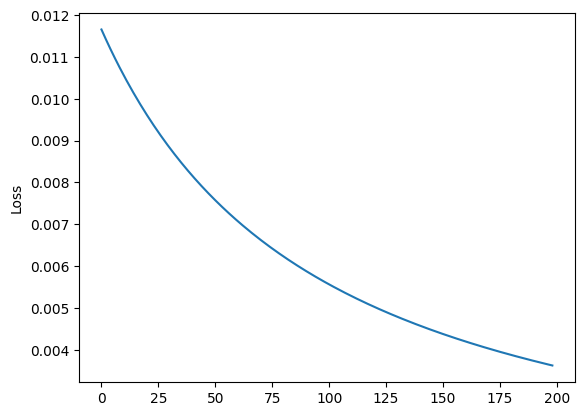

In [54]:
import matplotlib.pyplot as plt
plt.plot(all_losses)
plt.ylabel('Loss')
plt.show()

In [24]:
# list(network.parameters())[0].data = torch.Tensor([[10.], [-10]])
# list(network.parameters())[1].data = torch.Tensor([-5., 15])
np.set_printoptions(precision=2)
params = list(network.parameters())
par = []
for p in params:
    par.append(p.detach())
    print (par[-1])

tensor([-1.5000])
tensor([[15.2505],
        [15.9158]])
tensor([1.4539, 0.7973])


In [26]:
o1 = train_x @ par[1].T + par[2]
o1

tensor([[ 1.4539,  0.7973],
        [16.7044, 16.7131],
        [31.9548, 32.6288]])

In [27]:
a1 = torch.sigmoid(o1)
a1

tensor([[0.8106, 0.6894],
        [1.0000, 1.0000],
        [1.0000, 1.0000]])

In [56]:
o2 = a1[:, 0] + a1[:, 1] - 1
mseloss(o2, train_y)

tensor(0.4356)

In [49]:
o2 @ par[2].T

tensor([[3.7133],
        [3.7137],
        [3.7140],
        [3.5771]])

In [23]:
network.forward(train_x)

tensor([[0.0000],
        [0.5000],
        [0.5000]], grad_fn=<AddBackward0>)